In [ ]:
import requests

file_url = "https://raw.githubusercontent.com/danilonicioka/mlops-workflow/refs/heads/main/tests/all_tests.csv"

data_path = "/content/all_tests.csv"

try:
    response = requests.get(file_url)
    response.raise_for_status()
    with open(data_path, "wb") as file:
        file.write(response.content)
except requests.exceptions.RequestException as e:
    print(f"Error: {e}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import scipy.stats as st

def qqanalise(dados,distr="norm"):
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.hist(dados)
  plt.subplot(1,2,2)
  st.probplot(dados, dist=distr,plot=plt)
  plt.show()

dados=pd.read_csv(data_path)
dados

,Index,F1,F2,F3,Replica,Average
0,1,Kserve,1/2,1,1,19.773657
1,2,Kserve,1/2,1,2,19.695789
2,3,Kserve,1/2,1,3,19.549549
3,4,Kserve,1/2,1,4,20.151248
4,5,Kserve,1/2,1,5,19.443194
...,...,...,...,...,...,...
535,536,Local,1/12,6,26,5.443275
536,537,Local,1/12,6,27,4.422307
537,538,Local,1/12,6,28,5.537897
538,539,Local,1/12,6,29,2.563804


<Axes: title={'center': 'Average'}, xlabel='[F1]'>

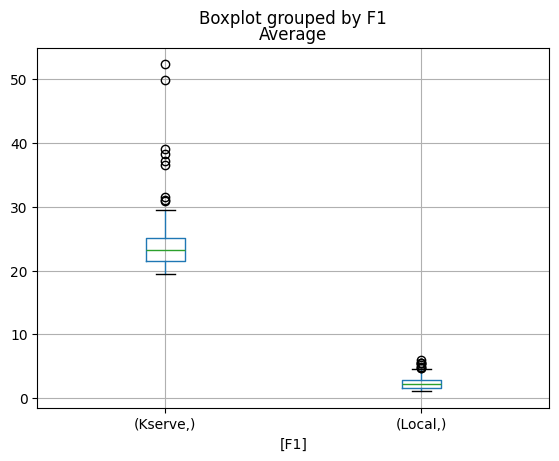

In [ ]:
dados.boxplot(column="Average",by=["F1"])

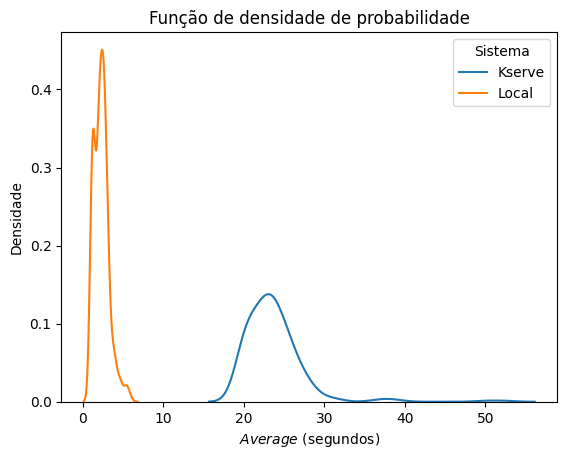

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

dados1 = dados[dados.F1=="Kserve"].Average
dados2 = dados[dados.F1=="Local"].Average

sns.kdeplot(dados1, label="Kserve")
sns.kdeplot(dados2, label="Local")
plt.ylabel("Densidade")
plt.xlabel("$Average$ (segundos)")
plt.legend(title="Sistema")
plt.title("Função de densidade de probabilidade")
plt.show()

A partir da diferença entre as distribuições é evidente que os resultados com Kserve são maiores que os de Local. Não há necessidade de uso de teste de hipótese neste caso.

Pode-se comentar que há uma maior variabilidade no Kserve (por quê?). Pode-se comentar sobre a presença de valores que são o dobro do valor da mediana (acho que o por quê é o mesmo do anterior). Pode-se comentar sobre a "gordura" que o Kserve adiciona.

As próximas análises nos permitem avaliar o impacto dos outros fatores em cada um dos casos, separadamente.

**Impacto dos fatores F2 e F3 sobre o Kserve**

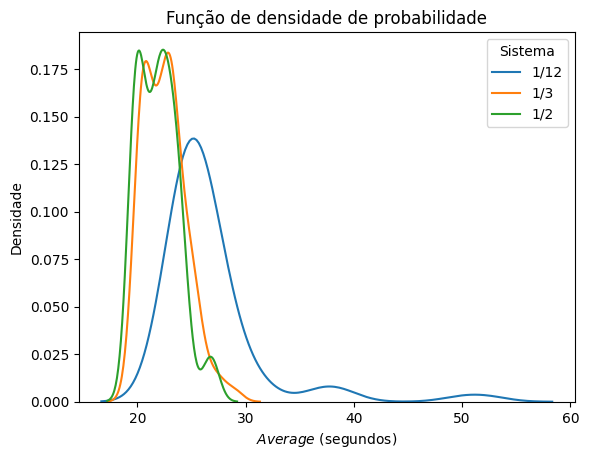

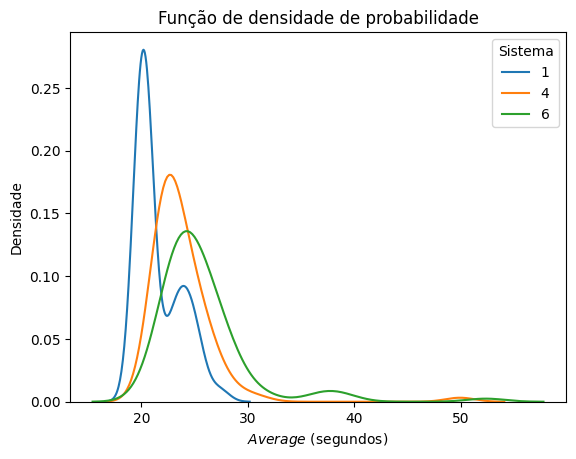

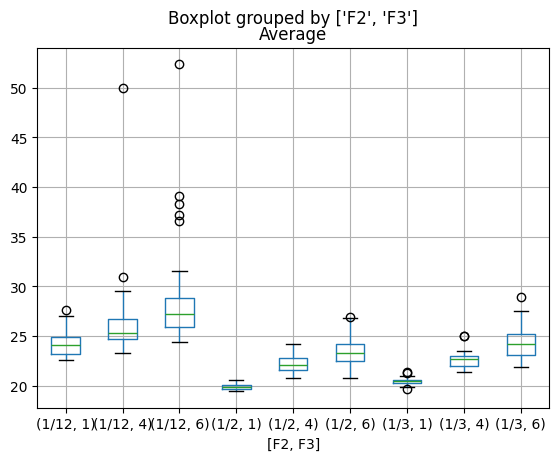

KruskalResult(statistic=215.46316796501287, pvalue=3.497794644354539e-42)
WilcoxonResult(statistic=28.0, pvalue=2.7623027563095093e-06)
WilcoxonResult(statistic=150.0, pvalue=0.09194962680339813)
WilcoxonResult(statistic=145.0, pvalue=0.07324407435953617)


In [ ]:
dados_kserve = dados[dados.F1=="Kserve"]

dados1 = dados_kserve[dados_kserve.F2=="1/12"].Average
dados2 = dados_kserve[dados_kserve.F2=="1/3"].Average
dados3 = dados_kserve[dados_kserve.F2=="1/2"].Average

sns.kdeplot(dados1, label="1/12")
sns.kdeplot(dados2, label="1/3")
sns.kdeplot(dados3, label="1/2")
plt.ylabel("Densidade")
plt.xlabel("$Average$ (segundos)")
plt.legend(title="Sistema")
plt.title("Função de densidade de probabilidade")
plt.show()

dados1 = dados_kserve[dados_kserve.F3==1].Average
dados2 = dados_kserve[dados_kserve.F3==4].Average
dados3 = dados_kserve[dados_kserve.F3==6].Average

sns.kdeplot(dados1, label="1")
sns.kdeplot(dados2, label="4")
sns.kdeplot(dados3, label="6")
plt.ylabel("Densidade")
plt.xlabel("$Average$ (segundos)")
plt.legend(title="Sistema")
plt.title("Função de densidade de probabilidade")
plt.show()

dados_kserve.boxplot(column="Average",by=["F2","F3"])
plt.show()

x = dados_kserve.groupby(["F2","F3"])["Average"]

dados1 = x.get_group(("1/12",1))
dados2 = x.get_group(("1/12",4))
dados3 = x.get_group(("1/12",6))

dados4 = x.get_group(("1/3",1))
dados5 = x.get_group(("1/3",4))
dados6 = x.get_group(("1/3",6))

dados7 = x.get_group(("1/2",1))
dados8 = x.get_group(("1/2",4))
dados9 = x.get_group(("1/2",6))

#model = ols("""Average ~ C(F2) + C(F3) + C(F2):C(F3)""", data=dados_kserve).fit()
#print(sm.stats.anova_lm(model, typ=1))

#print(st.shapiro(model.resid))
#qqanalise(model.resid)

print(st.kruskal(dados1,dados2,dados3,dados4,dados5,dados6,dados7,dados8,dados9))
print(st.wilcoxon(dados4,dados7))
print(st.wilcoxon(dados5,dados8))
print(st.wilcoxon(dados6,dados9))

Pode-se ver que quando F2=1/12, há uma diferença significativa nos valores de Average. Contudo, para F2=1/2 e 1/3 os valores de Average são mais próximos entre si.

O teste de Wilcoxon comparando a Average no caso em que F2=1/2 e F2=1/3, conservando o valor de F3=1, indica que há diferença significativa entre estes casos. Já nas demais comparações, nos casos para F3=4 e F3=6, não podemos rejeitar a hipótese nula.

**Impacto dos fatores F2 e F3 sobre o Local**


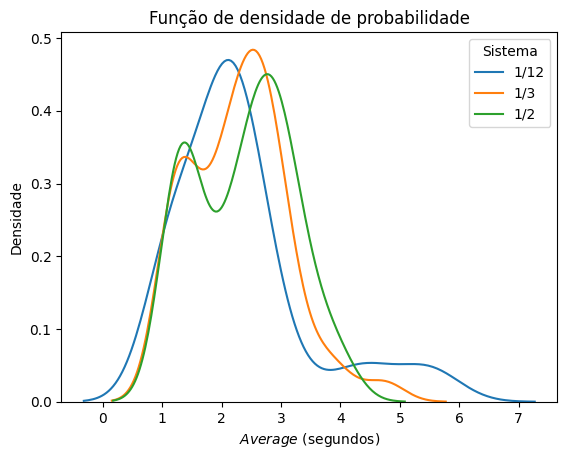

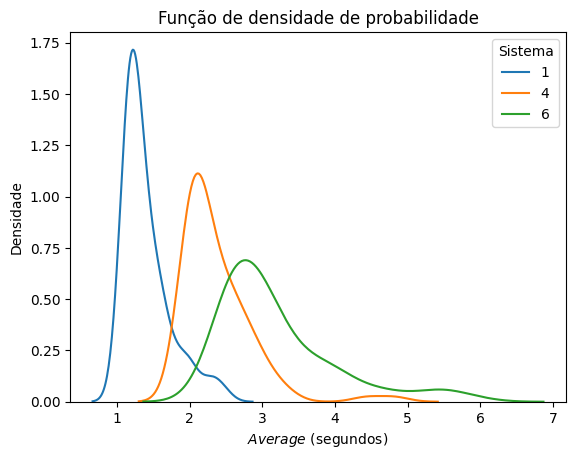

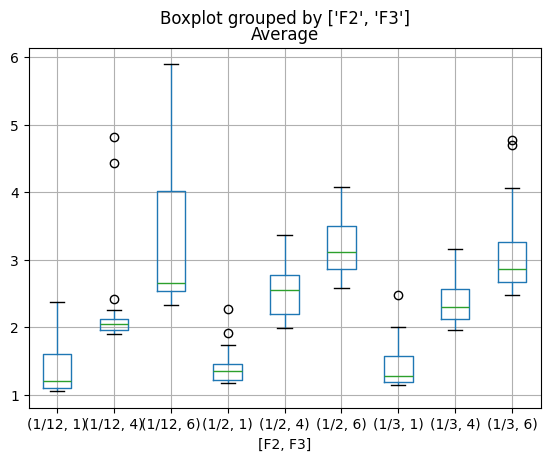

KruskalResult(statistic=5.548069791808871, pvalue=0.06240967947128561)
KruskalResult(statistic=203.37968384128294, pvalue=6.865351667743975e-45)


<ipython-input-13-6ebcfb774d14>:34: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  dados1 = x.get_group("1/12")
<ipython-input-13-6ebcfb774d14>:35: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  dados2 = x.get_group("1/3")
<ipython-input-13-6ebcfb774d14>:36: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  dados3 = x.get_group("1/2")
<ipython-input-13-6ebcfb774d14>:42: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to

In [ ]:
dados_kserve = dados[dados.F1=="Local"]

dados1 = dados_kserve[dados_kserve.F2=="1/12"].Average
dados2 = dados_kserve[dados_kserve.F2=="1/3"].Average
dados3 = dados_kserve[dados_kserve.F2=="1/2"].Average

sns.kdeplot(dados1, label="1/12")
sns.kdeplot(dados2, label="1/3")
sns.kdeplot(dados3, label="1/2")
plt.ylabel("Densidade")
plt.xlabel("$Average$ (segundos)")
plt.legend(title="Sistema")
plt.title("Função de densidade de probabilidade")
plt.show()

dados1 = dados_kserve[dados_kserve.F3==1].Average
dados2 = dados_kserve[dados_kserve.F3==4].Average
dados3 = dados_kserve[dados_kserve.F3==6].Average

sns.kdeplot(dados1, label="1")
sns.kdeplot(dados2, label="4")
sns.kdeplot(dados3, label="6")
plt.ylabel("Densidade")
plt.xlabel("$Average$ (segundos)")
plt.legend(title="Sistema")
plt.title("Função de densidade de probabilidade")
plt.show()

dados_kserve.boxplot(column="Average",by=["F2","F3"])
plt.show()

x = dados_kserve.groupby(["F2"])["Average"]

dados1 = x.get_group(("1/12"))
dados2 = x.get_group(("1/3"))
dados3 = x.get_group(("1/2"))

print(st.kruskal(dados1,dados2,dados3))

x = dados_kserve.groupby(["F3"])["Average"]

dados4 = x.get_group((1))
dados5 = x.get_group((4))
dados6 = x.get_group((6))

print(st.kruskal(dados4,dados5,dados6))

#model = ols("""Average ~ C(F2) + C(F3) + C(F2):C(F3)""", data=dados_kserve).fit()
#print(sm.stats.anova_lm(model, typ=1))

#print(st.shapiro(model.resid))
#qqanalise(model.resid)

O teste de kruskal entre os grupos e os driagramas de densidade indicam que:

1. não podemos rejeitar a hipótese de igualdade no caso da comparação dos grupos formados pelos níveis do fator F2
2. há diferença significativa entre os grupos formados pelos níveis do fator F3